In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import random
import seaborn as sns
from scipy.stats import skew, kurtosis, gaussian_kde
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer

random.seed(8)
%matplotlib inline
sns.set()

breast_cancer = load_breast_cancer()
print(breast_cancer.data.shape)

(569, 30)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()


def create_numeric_df(df):
    return df.select_dtypes(include=[np.number])

def create_non_numeric_df(df):
    return df.select_dtypes(exclude=[np.number])

def calc_coefficient_of_variation(df_description):
    """Calculates the coefficient of variation
    for each variable in a dataframe produced
    by df.describe()
    
    Args:
        df_description: A pandas df built from df.describe
    
    Returns:
        A pandas df in the format of df.describe but with 
        the coef of var included as an additional row.
    """
    coef_variation = df_description.loc["std"] / df_description.loc["mean"]
    df_description.loc["coef_var"] = coef_variation
    return df_description.sort_values(by="coef_var", axis=1)


def describe_numeric_data(df):
    """Produces a df of summary stats for the numeric
    columns in a df in the style of df.describe() but 
    the coefficient of variation is included as well.
    """
    df_description = df.describe(include=[np.number])
    return calc_coefficient_of_variation(df_description)


def describe_non_numeric_data(df):
    """Produces a df of summary stats for the non-numeric
    columns in a df in the style of df.describe().
    """
    return df.describe(exclude=[np.number])

def plot_coef_of_variation(df, cutoff=0):
    """Creates a plot of the numeric variables in a pandas df
    that have the largest coefficient of variation.
    
    Args:
        df: A pandas dataframe
        cutoff: A float. Any value for the coefficient of 
            variation that is larger than the cutoff
            will be included in the plot.
        Returns: A seaborn barplot of the coef of variation
            plotted in order of largest to smallest."""
    df_num_description = describe_numeric_data(df)
    df_coef_var = df_num_description.loc[['coef_var']][df_num_description > cutoff]
    df_coef_var = df_coef_var.dropna(axis=1).transpose().sort_values('coef_var',ascending=False)
    df_coef_var['numeric_vars'] = df_coef_var.index
    plot_coef_var = sns.barplot(x="numeric_vars", y="coef_var", data=df_coef_var, color='lightslategrey')
    plot_coef_var = plt.setp(plot_coef_var.get_xticklabels(), rotation=80)
    return plot_coef_var[1]
    

def sklearn_data_to_pandas_df(sklearn_data):
    """ Converts sklearn datasets to a pandas df.
    """
    cols = list(sklearn_data['feature_names']) + ['target']
    dataframe = pd.DataFrame(data= np.c_[sklearn_data['data'], sklearn_data['target']], columns= cols)
    return dataframe

def _offset(key, key_range, value, max_value):
    return (key - key_range * 0.0125, value + max_value * 0.01)

def counter_histogram(labels):
    """Produces a histogram from a list or pandas 
    series with the counts of each category 
    printed above the bar.
    
    Args:
        labels: A pandas series or list. The values
            inside will be tallied to create the histogram.
    """
    counts = Counter(labels)
    fig, ax = plt.subplots()
    int_keys = [int(k) for k in counts.keys()]
    ax.bar(int_keys, list(counts.values()), color=bar_color)
    ax.set_xticks(sorted(int_keys))

    k_range = max(counts.keys()) - min(counts.keys())
    max_v = max(counts.values())

    for (k, v) in counts.items():
        ax.annotate(str(v), _offset(k, k_range, v, max_v))


def get_top_abs_correlations(df_numeric, n=5):
    """Get the variable combinations that yeild the
    highest absolute correlation.
    
    Args:
        df_numeric: A pandas df with only numeric columns
        n: An integer representing how many of the top 
            variable combinations to return.
    """
    df_corr = df_numeric.corr()
    df_top_corr = (df_corr.abs()
          .where(np.triu(np.ones(df_corr.shape), k=1).astype(np.bool))
          .stack()
          .sort_values(ascending=False))
    return df_top_corr[:n]

In [3]:
df = sklearn_data_to_pandas_df(breast_cancer)
df['diagnosis'] = np.where(df['target']==0, 'malignant', 'benign')
df['large mean concavity'] = np.where(df['mean concavity']>df['mean concavity'].median(), 'large', 'small')

df.head(20)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,diagnosis,large mean concavity
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,2019.0,0.1622,0.6656,0.7119,0.26540,0.4601,0.11890,0.0,malignant,large
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,1956.0,0.1238,0.1866,0.2416,0.18600,0.2750,0.08902,0.0,malignant,large
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,1709.0,0.1444,0.4245,0.4504,0.24300,0.3613,0.08758,0.0,malignant,large
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,567.7,0.2098,0.8663,0.6869,0.25750,0.6638,0.17300,0.0,malignant,large
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,1575.0,0.1374,0.2050,0.4000,0.16250,0.2364,0.07678,0.0,malignant,large
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,741.6,0.1791,0.5249,0.5355,0.17410,0.3985,0.12440,0.0,malignant,large
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,0.0,malignant,large
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,0.0,malignant,large
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,739.3,0.1703,0.5401,0.5390,0.20600,0.4378,0.10720,0.0,malignant,large
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,711.4,0.1853,1.0580,1.1050,0.22100,0.4366,0.20750,0.0,malignant,large


In [4]:
df['mean concavity'].median()

0.06154

In [5]:
df = df.sample(n=300)

numeric_cols = list(df.select_dtypes(include=[np.number]).columns)
non_num_cols = list(df.select_dtypes(exclude=[np.number]).columns)
y = 'target'
exclusions = [y, 'diagnosis']
X = [col for col in df.columns if col not in exclusions]
X_numeric = [col for col in numeric_cols if col not in exclusions]

In [6]:
describe_numeric_data(df)
# describe_non_numeric_data(df)

,mean fractal dimension,mean smoothness,mean symmetry,worst smoothness,worst fractal dimension,worst symmetry,mean texture,worst texture,mean radius,mean perimeter,...,worst area,compactness error,radius error,target,worst concavity,perimeter error,mean concave points,mean concavity,concavity error,area error
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,0.063012,0.096665,0.180424,0.132743,0.083442,0.287092,19.219367,25.495767,13.950300,90.764200,...,856.068667,0.025226,0.401622,0.653333,0.260288,2.832518,0.047519,0.086006,0.031597,39.685440
std,0.006874,0.013875,0.025953,0.021909,0.016787,0.061358,4.296385,5.984557,3.479642,23.941920,...,565.168283,0.016807,0.289179,0.476704,0.191852,2.151629,0.036236,0.074471,0.027749,51.377272
min,0.049960,0.062510,0.116700,0.071170,0.055250,0.160300,9.710000,12.020000,7.691000,48.340000,...,223.600000,0.002252,0.114400,0.000000,0.000000,0.771400,0.000000,0.000000,0.000000,7.326000
25%,0.058830,0.087060,0.161975,0.117575,0.071205,0.247925,16.405000,21.397500,11.600000,74.337500,...,510.275000,0.013815,0.233225,0.000000,0.115900,1.595750,0.020833,0.029337,0.015130,17.655000
50%,0.061790,0.096515,0.178000,0.132500,0.080075,0.278850,18.830000,25.245000,13.145000,85.525000,...,644.800000,0.020210,0.326950,1.000000,0.210800,2.295500,0.033010,0.060070,0.025850,24.565000
75%,0.065940,0.104225,0.194300,0.146000,0.091705,0.316575,21.540000,29.415000,15.467500,102.425000,...,982.050000,0.031125,0.476050,1.000000,0.376525,3.306000,0.067908,0.119975,0.040698,44.665000
max,0.097440,0.163400,0.267800,0.222600,0.173000,0.663800,39.280000,45.410000,28.110000,188.500000,...,4254.000000,0.093680,2.873000,1.000000,1.252000,21.980000,0.184500,0.363500,0.303800,542.200000
coef_var,0.109092,0.143531,0.143846,0.165047,0.201180,0.213721,0.223545,0.234727,0.249431,0.263782,...,0.660190,0.666250,0.720027,0.729648,0.737074,0.759617,0.762562,0.865879,0.878209,1.294613


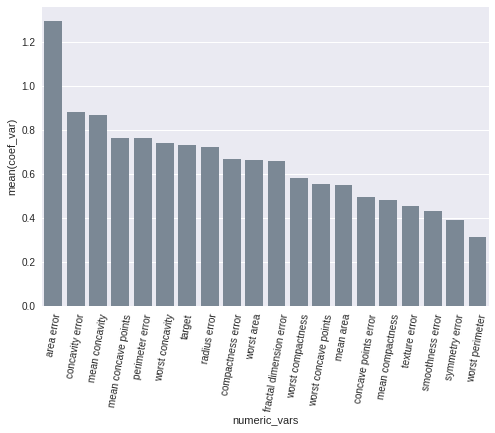

In [7]:
plot_coef_var = plot_coef_of_variation(df, cutoff=0.3)

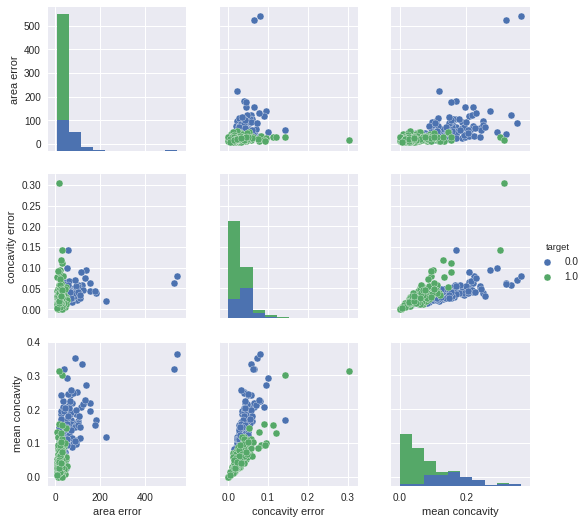

In [8]:
# plot vars with greatest coef of variation
pair_plot = sns.pairplot(df, vars=['area error', 'concavity error', 'mean concavity'], hue = y)

# Save plot to pdf
pp = PdfPages('pair_plot.pdf')
pp.savefig(pair_plot.fig,  bbox_inches='tight')
pp.close()

/home/edward/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


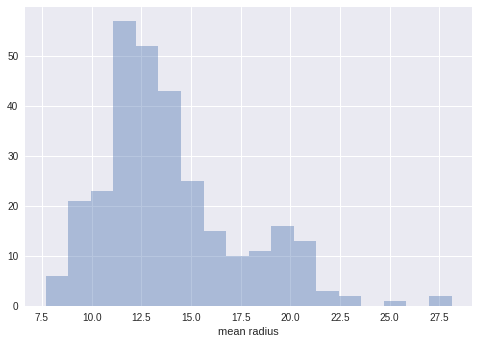

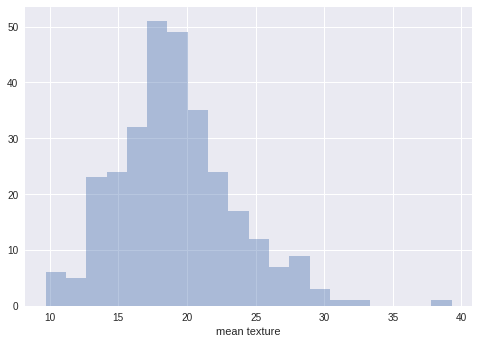

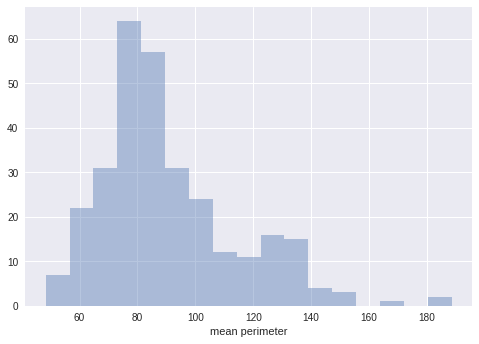

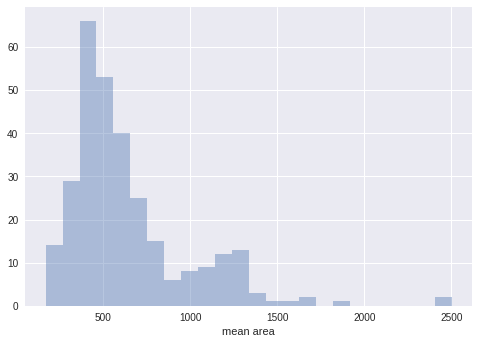

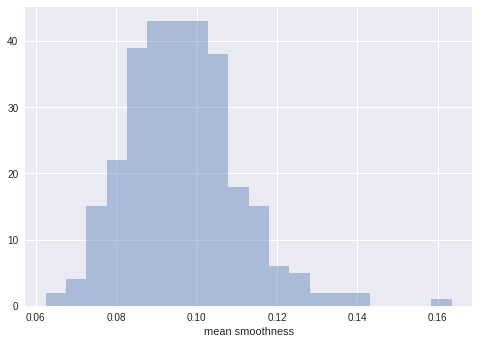

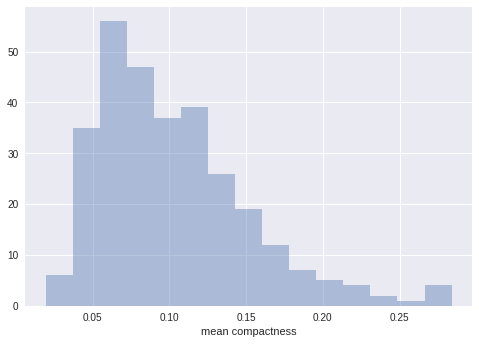

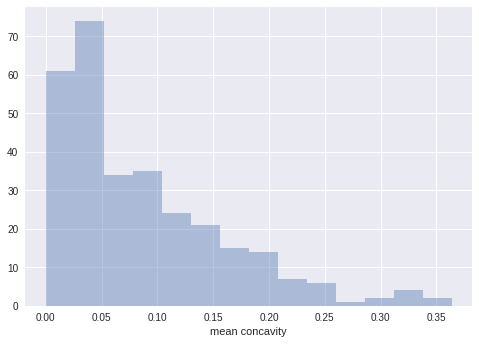

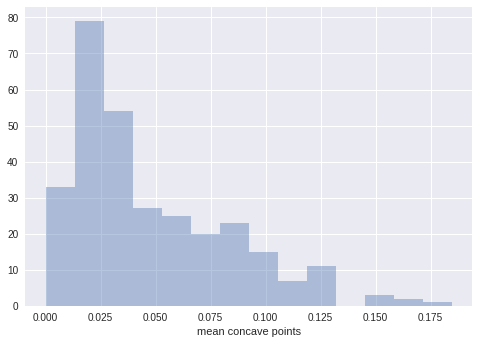

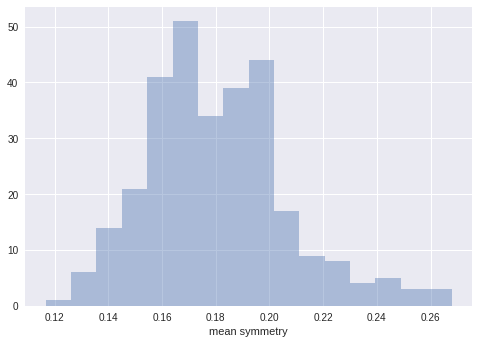

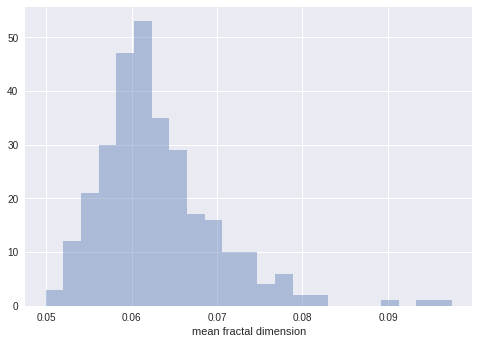

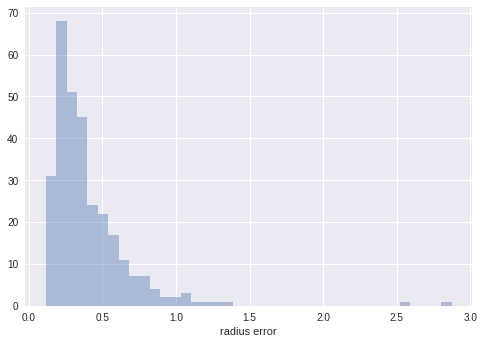

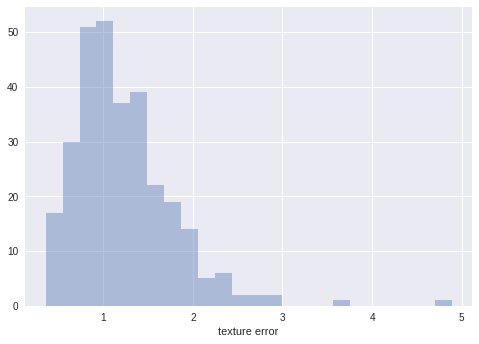

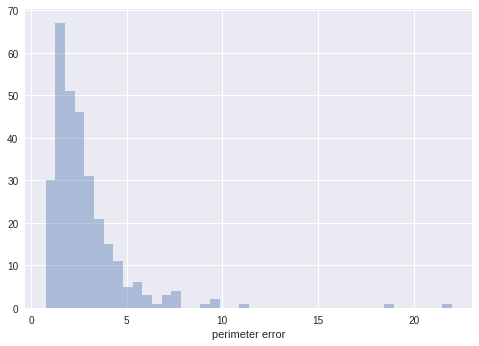

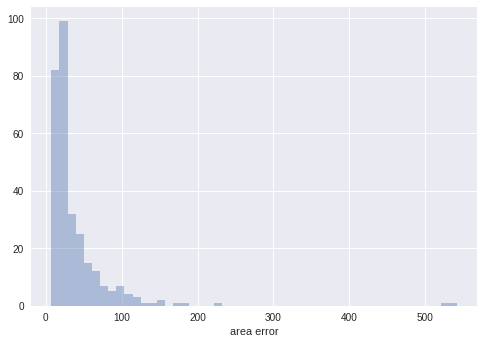

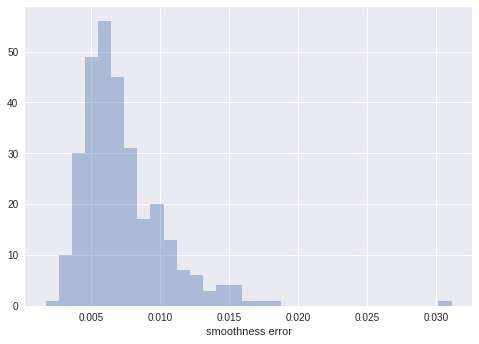

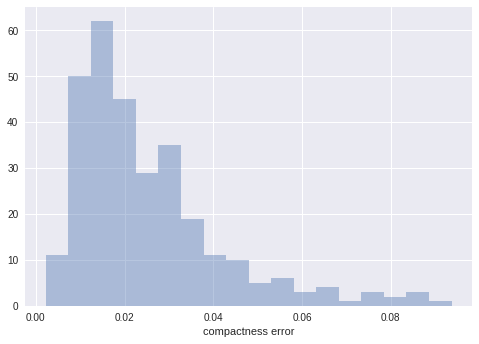

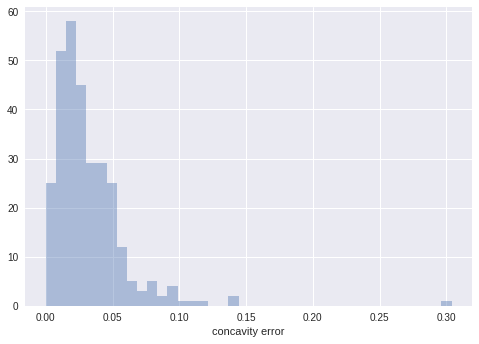

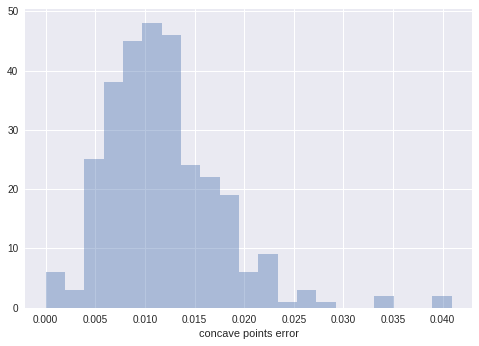

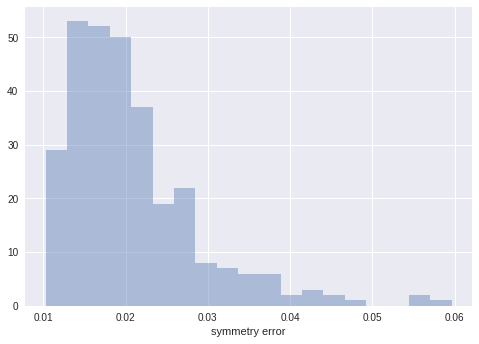

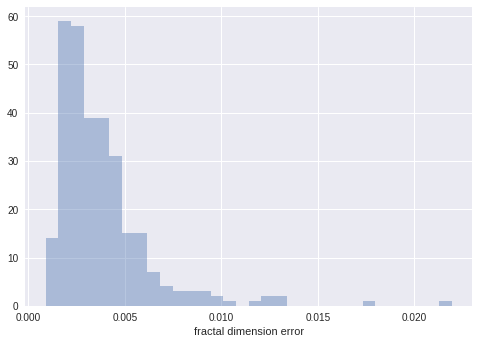

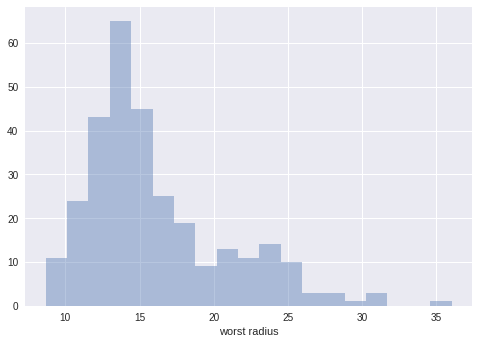

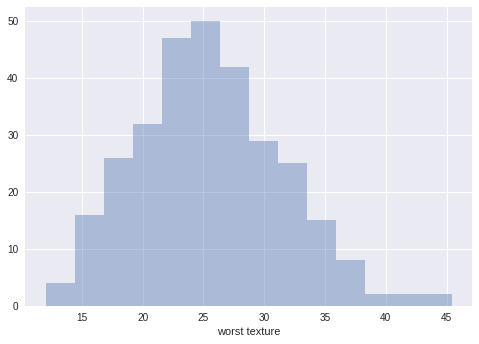

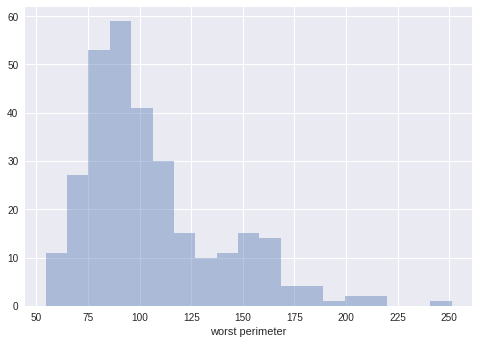

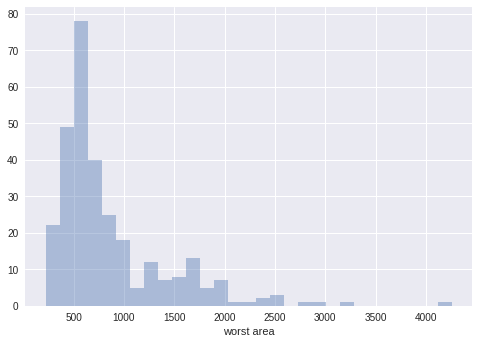

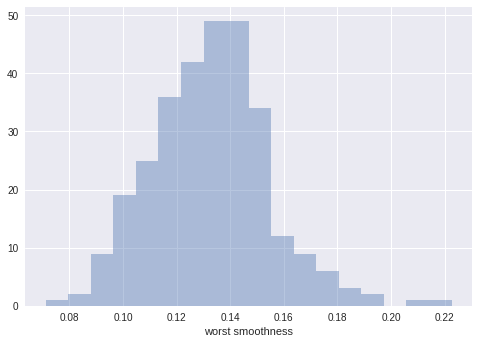

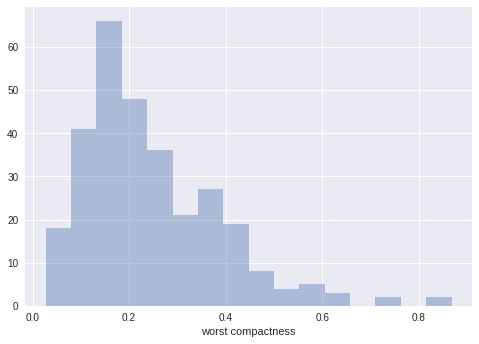

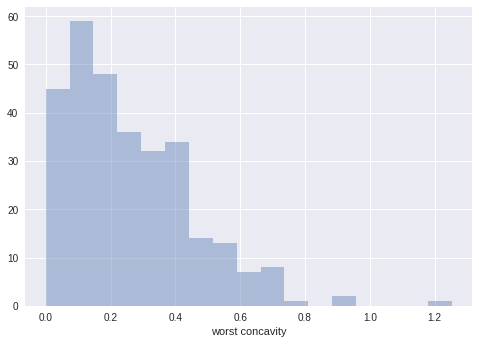

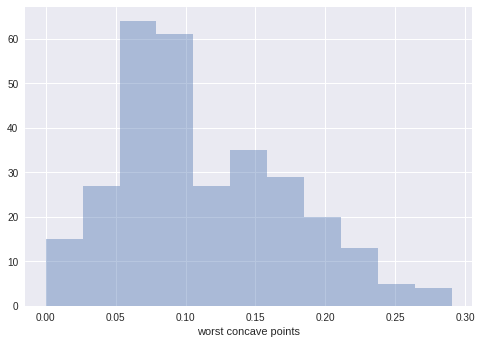

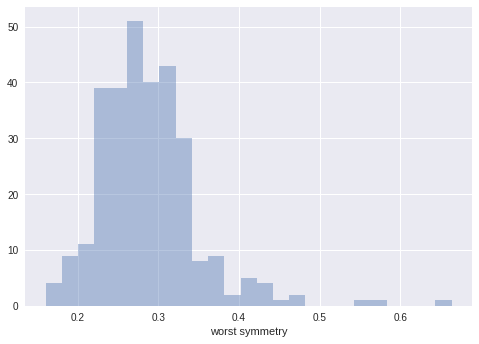

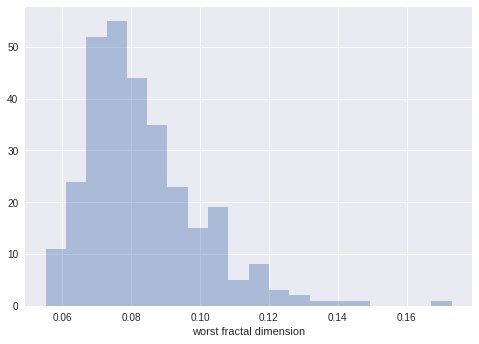

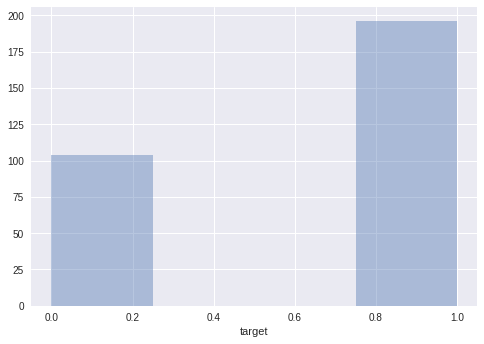

In [9]:
#df_numeric = create_numeric_df(df)
#df_cat = create_non_numeric_df(df)

for i, col in enumerate(numeric_cols):
    plt.figure(i)
    sns.distplot(df[numeric_cols][col], kde=False)

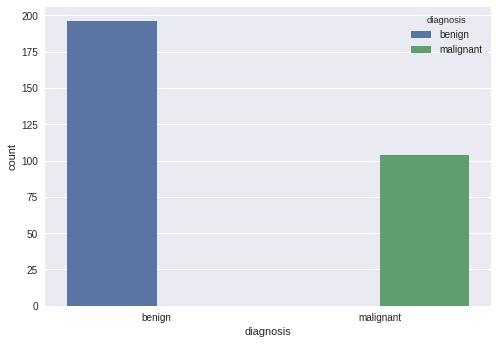

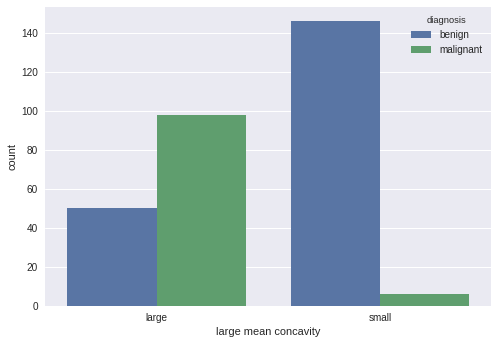

In [10]:
for i, col in enumerate(non_num_cols):
    plt.figure(i)
    sns.countplot(x=col, data=df[non_num_cols], hue='diagnosis')

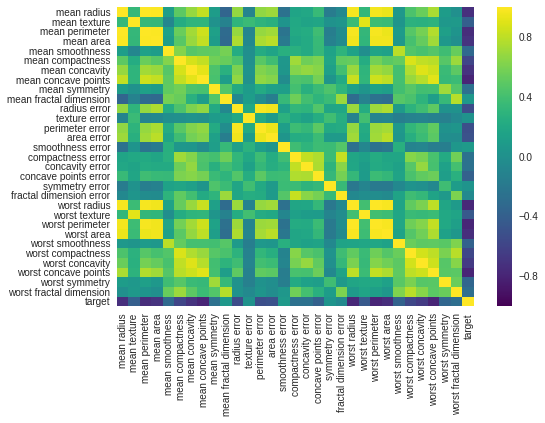

In [11]:
df_corr = df[numeric_cols].corr()
sns.heatmap(df_corr, cmap='viridis')

In [12]:
get_top_abs_correlations(df[numeric_cols])

mean radius     mean perimeter     0.998140
worst radius    worst perimeter    0.994801
mean radius     mean area          0.985539
mean perimeter  mean area          0.985011
worst radius    worst area         0.982246
dtype: float64

## Identifying structure through unsupervised learning
* In addition to looking for deviations, it is important to identify the latent structure in the data. 
* Hierarchical clustering algorithms are good because you don't need to specify a cluster count. 

* Hierarchical clustering algorithms also gives your variables a partial order, which you can take advantage of. 
* My preferred form of clustering is a technique called HDBSCAN.
* It takes the minimum cluster size as the only parameter, and it produces both discrete and hierarchical clustering.

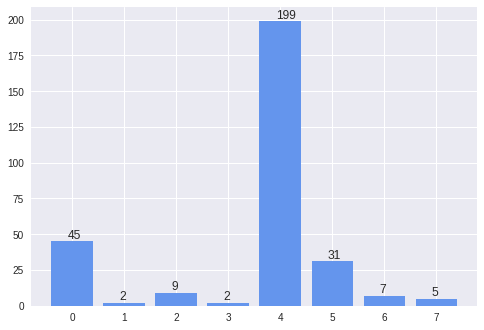

In [13]:
bar_color = "cornflowerblue"
df_standardized = pd.DataFrame(StandardScaler().fit_transform(df[numeric_cols]),
                               columns=numeric_cols,
                               index=df[numeric_cols].index)


# fit = DBSCAN(min_samples=15).fit(standardized_df)
fit = SpectralClustering(n_clusters = 8).fit(df_standardized)
base_sample_clusters = pd.Series(fit.labels_, index=df_standardized.index)
counter_histogram(base_sample_clusters)

In [14]:
#df_standardized.describe()

In [18]:
X_tsne = TSNE(n_components=2, learning_rate=100).fit_transform(df_standardized[X_numeric])
X_pca = PCA(n_components=2).fit_transform(df_standardized[X_numeric])

In [16]:
df_manifold = pd.DataFrame({'tsne_0':X_tsne[:, 0], 
                            'tsne_1':X_tsne[:, 1], 
                            'pca_0': X_pca[:, 0], 
                            'pca_1': X_pca[:, 1], 
                            y: df[y]})

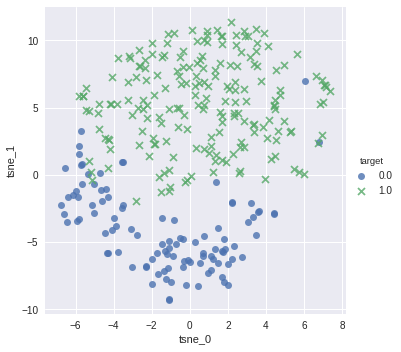

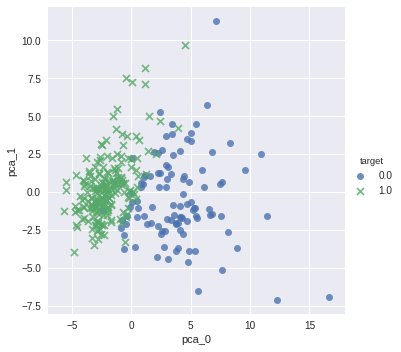

In [26]:
%matplotlib inline

sns.lmplot("tsne_0", "tsne_1", data=df_manifold, hue=y, fit_reg=False, markers=["o", "x"])
sns.lmplot("pca_0", "pca_1", data=df_manifold, hue=y, fit_reg=False, markers=["o", "x"])

<IPython.core.display.Javascript object>


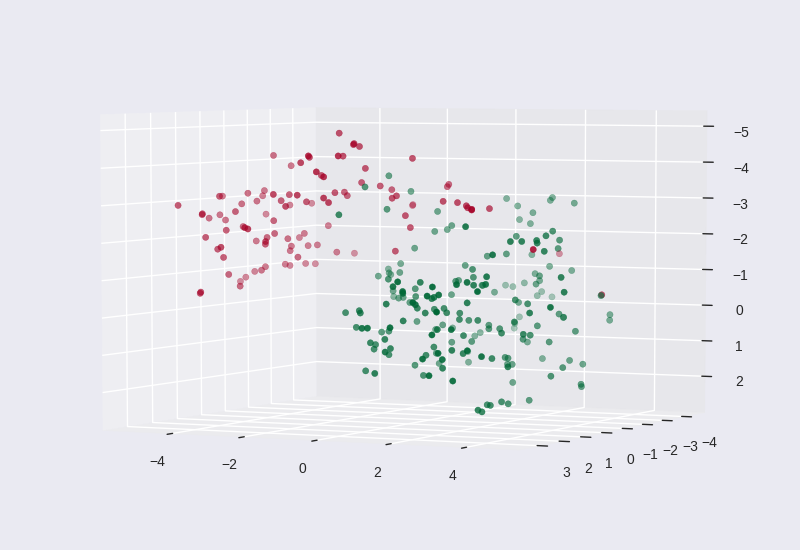

In [30]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = Axes3D(fig)

X_tsne_3d = TSNE(n_components=3, learning_rate=100).fit_transform(df_standardized[X_numeric])
ax.scatter(X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], c=df[y], cmap=plt.cm.RdYlGn)
plt.show()